In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from matplotlib.patches import Circle
import astropy.units as u
import sunpy.map
from AntennaUtils import *  

# Imprimimos estadísticas resumidas del DataFrame final
pd.set_option('display.float_format', '{:.10f}'.format)

In [4]:
# RT32 location (Ventspils, Latvia)
rt32_antenna = RT32()
rt32_antenna.set_location(latitude=57.5535171694, longitude=21.8545525000, elevation=20)

# Define constants
path = ''
year = 2024
month = 2
day = 15
hour_start = 11
minute_start = 25

temperature = u.Quantity(15.5, unit=u.deg_C)
pressure = u.Quantity(1013.25, unit=u.hPa)
relative_humidity = u.Quantity(70.0, unit=u.percent)
obswl =u.Quantity(50000, unit=u.nm) 

weather = Weather(temperature, pressure, relative_humidity, obswl)

observation = SpiralSunObservation(weather,rt32_antenna , year , month , day , hour_start , minute_start)

az_anten, el_anten , az_sun , el_sun , xx1 , yy1, utc = observation.calculatePositions()
observation.generateFile(path, az_anten , el_anten , utc)  

Starting calculation
-------------------------------------------------------------
Saved:  sun_scan_240215_1125.ptf    3300   points


True

In [5]:
# Create DataFrame
sunPositionDf = pd.DataFrame({'UTC': utc,'SunX': xx1, 'SunY': yy1  })

fit_file_path = "lnsp4_5ch_240215_112029_122509.fit"
hdu_number = 1  # Number of the extension containing the binary table

# Converts the binary table to a Pandas DataFrame
data_df = bintable_to_pandas(fit_file_path, hdu_number)



In [6]:

band_data_dfs = processData(data_df)

print(band_data_dfs.keys())

Renaming columns
Index(['LCP 4.07GHZ', 'LCP 6.42GHZ', 'LCP 8.40GHZ', 'LCP 9.80GHZ',
       'LCP 11.90GHZ', 'RCP 4.07GHZ', 'RCP 6.42GHZ', 'RCP 8.40GHZ',
       'RCP 9.80GHZ', 'RCP 11.90GHZ', 'UTC LCP 4.07GHZ', 'UTC LCP 6.42GHZ',
       'UTC LCP 8.40GHZ', 'UTC LCP 9.80GHZ', 'UTC LCP 11.90GHZ',
       'UTC RCP 4.07GHZ', 'UTC RCP 6.42GHZ', 'UTC RCP 8.40GHZ',
       'UTC RCP 9.80GHZ', 'UTC RCP 11.90GHZ'],
      dtype='object')
dict_keys(['4.07GHZ', '6.42GHZ', '8.40GHZ', '9.80GHZ', '11.90GHZ'])


In [7]:
processed_dfs = getFinalProcessedData(observation , sunPositionDf,band_data_dfs)

print(processed_dfs)

Interpolating data...
Filtering data...
Index(['UTC', 'SunX', 'SunY', 'UTC_4.07GHZ', 'STOKE_I_4.07GHZ',
       'STOKE_V_4.07GHZ'],
      dtype='object')
Calibrating data...


c:\Users\2012m\Desktop\RT-32-SunImage\AntennaUtils.py:548: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rest_of_df[f'STOKE_I_{band}'] = (rest_of_df[f'STOKE_I_{band}'] - min_vect[0]) / (max_vect[0] - min_vect[0])
c:\Users\2012m\Desktop\RT-32-SunImage\AntennaUtils.py:549: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rest_of_df[f'STOKE_V_{band}'] = (rest_of_df[f'STOKE_V_{band}'] - min_vect[1]) / (max_vect[1] - min_vect[1])
c:\Users\2012m\Desktop\RT-32-SunImage\AntennaUtils.py:552: SettingWithCopyWarning: 
A 

Index(['UTC', 'SunX', 'SunY', 'UTC_6.42GHZ', 'STOKE_I_6.42GHZ',
       'STOKE_V_6.42GHZ'],
      dtype='object')
Calibrating data...


c:\Users\2012m\Desktop\RT-32-SunImage\AntennaUtils.py:548: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rest_of_df[f'STOKE_I_{band}'] = (rest_of_df[f'STOKE_I_{band}'] - min_vect[0]) / (max_vect[0] - min_vect[0])
c:\Users\2012m\Desktop\RT-32-SunImage\AntennaUtils.py:549: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rest_of_df[f'STOKE_V_{band}'] = (rest_of_df[f'STOKE_V_{band}'] - min_vect[1]) / (max_vect[1] - min_vect[1])
c:\Users\2012m\Desktop\RT-32-SunImage\AntennaUtils.py:552: SettingWithCopyWarning: 
A 

Index(['UTC', 'SunX', 'SunY', 'UTC_8.40GHZ', 'STOKE_I_8.40GHZ',
       'STOKE_V_8.40GHZ'],
      dtype='object')
Calibrating data...


c:\Users\2012m\Desktop\RT-32-SunImage\AntennaUtils.py:548: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rest_of_df[f'STOKE_I_{band}'] = (rest_of_df[f'STOKE_I_{band}'] - min_vect[0]) / (max_vect[0] - min_vect[0])
c:\Users\2012m\Desktop\RT-32-SunImage\AntennaUtils.py:549: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rest_of_df[f'STOKE_V_{band}'] = (rest_of_df[f'STOKE_V_{band}'] - min_vect[1]) / (max_vect[1] - min_vect[1])
c:\Users\2012m\Desktop\RT-32-SunImage\AntennaUtils.py:552: SettingWithCopyWarning: 
A 

Index(['UTC', 'SunX', 'SunY', 'UTC_9.80GHZ', 'STOKE_I_9.80GHZ',
       'STOKE_V_9.80GHZ'],
      dtype='object')
Calibrating data...


c:\Users\2012m\Desktop\RT-32-SunImage\AntennaUtils.py:548: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rest_of_df[f'STOKE_I_{band}'] = (rest_of_df[f'STOKE_I_{band}'] - min_vect[0]) / (max_vect[0] - min_vect[0])
c:\Users\2012m\Desktop\RT-32-SunImage\AntennaUtils.py:549: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rest_of_df[f'STOKE_V_{band}'] = (rest_of_df[f'STOKE_V_{band}'] - min_vect[1]) / (max_vect[1] - min_vect[1])
c:\Users\2012m\Desktop\RT-32-SunImage\AntennaUtils.py:552: SettingWithCopyWarning: 
A 

Index(['UTC', 'SunX', 'SunY', 'UTC_11.90GHZ', 'STOKE_I_11.90GHZ',
       'STOKE_V_11.90GHZ'],
      dtype='object')
Calibrating data...


c:\Users\2012m\Desktop\RT-32-SunImage\AntennaUtils.py:548: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rest_of_df[f'STOKE_I_{band}'] = (rest_of_df[f'STOKE_I_{band}'] - min_vect[0]) / (max_vect[0] - min_vect[0])
c:\Users\2012m\Desktop\RT-32-SunImage\AntennaUtils.py:549: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rest_of_df[f'STOKE_V_{band}'] = (rest_of_df[f'STOKE_V_{band}'] - min_vect[1]) / (max_vect[1] - min_vect[1])
c:\Users\2012m\Desktop\RT-32-SunImage\AntennaUtils.py:552: SettingWithCopyWarning: 
A 

{'4.07GHZ':                   UTC           SunX           SunY      UTC_4.07GHZ  \
29   41160.9110000000   0.1354424234  -0.0181265673 41160.9110000000   
30   41162.9850000000   0.4404986484   0.0799492946 41162.9850000000   
31   41165.0450000000   0.6623686611   0.3649987034 41165.0450000000   
32   41167.1250000000   0.7190830365   0.7885130298 41167.1250000000   
33   41169.1920000000   0.5541091326   1.2594908488 41169.1920000000   
...               ...            ...            ...              ...   
1540 44290.1860000000 -18.4535997790 -34.3697978096 44290.1860000000   
1541 44292.2660000000 -14.6853266785 -36.3626582739 44292.2660000000   
1542 44294.3260000000 -10.7411324034 -37.9291545008 44294.3260000000   
1543 44296.3960000000  -6.6094711452 -39.0715003956 44296.3960000000   
1544 44298.4580000000  -2.3730153145 -39.7614903760 44298.4580000000   

      STOKE_I_4.07GHZ  STOKE_V_4.07GHZ                isoT_time  
29       1.0055785574     0.9173754557  2024-02-15T11:26:

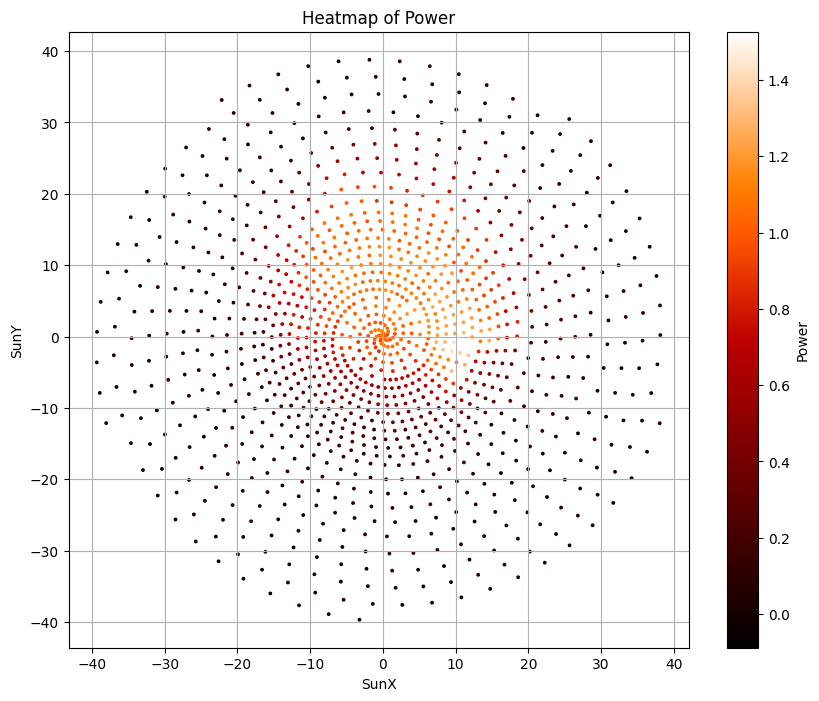

In [8]:
# Create the heatmap
Power = processed_dfs['11.90GHZ']["STOKE_I_11.90GHZ"].values 

plt.figure(figsize=(10, 8))
plt.scatter(processed_dfs['11.90GHZ']['SunX'], processed_dfs['11.90GHZ']['SunY'], c=Power, cmap='gist_heat',s=3)
plt.colorbar(label='Power')
plt.xlabel('SunX')
plt.ylabel('SunY')
plt.title('Heatmap of Power')
plt.grid(True)  # Display the grid for clarity
plt.show()

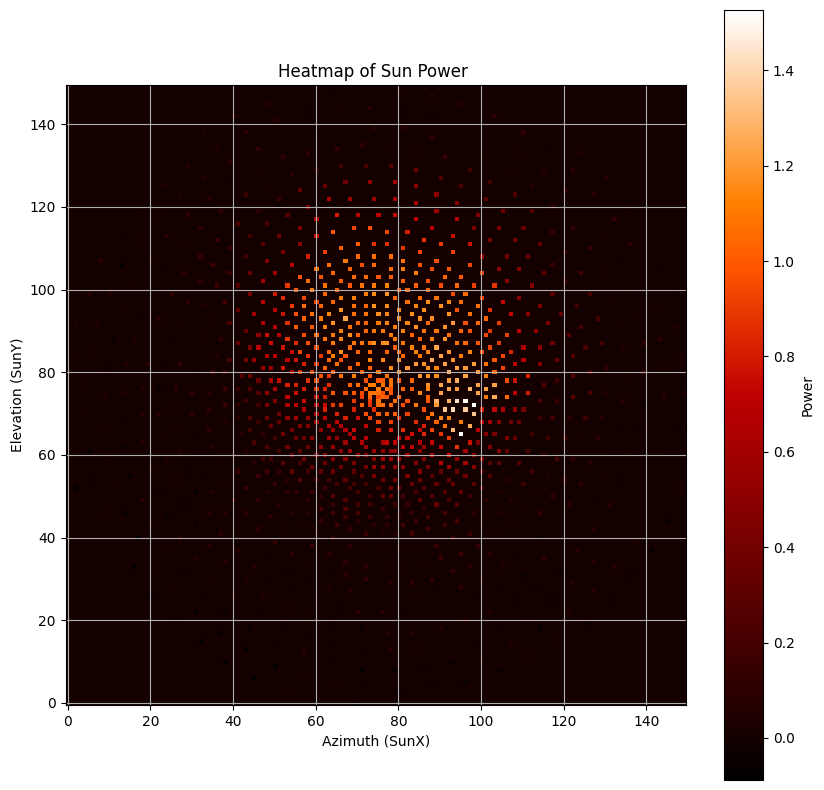

In [9]:
SunX = processed_dfs['11.90GHZ']['SunX']
SunY = processed_dfs['11.90GHZ']['SunY']
Power = processed_dfs['11.90GHZ']["STOKE_I_11.90GHZ"].values 

# Define the size of the grid and create a matrix of zeroes
grid_size = 150
grid_power = np.zeros((grid_size, grid_size))

# Calculate the scale for converting SunX and SunY coordinates to matrix indices
x_min, x_max = SunX.min(), SunX.max()
y_min, y_max = SunY.min(), SunY.max()
x_range = x_max - x_min
y_range = y_max - y_min

# Convert SunX and SunY coordinates to matrix indices
grid_x_index = ((SunX - x_min) / x_range * (grid_size - 1)).astype(int)
grid_y_index = ((SunY - y_min) / y_range * (grid_size - 1)).astype(int)

# Assign Power values to the matrix in the corresponding positions
grid_power[grid_y_index, grid_x_index] = Power

# Show the image
plt.figure(figsize=(10, 10))
plt.imshow(grid_power, cmap='gist_heat', origin='lower')
plt.colorbar(label='Power')
plt.xlabel('Azimuth (SunX)')
plt.ylabel('Elevation (SunY)')
plt.title('Heatmap of Sun Power ')
plt.grid(True)  # Display the grid for clarity
plt.show()


In [10]:
band_processed_helio_dfs = process_all_heliocentric_coordinates(processed_dfs, observation)


c:\Users\2012m\Desktop\RT-32-SunImage\AntennaUtils.py:645: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  band_df['az_anten'] = az_anten
c:\Users\2012m\Desktop\RT-32-SunImage\AntennaUtils.py:646: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  band_df['el_anten'] = el_anten
c:\Users\2012m\Desktop\RT-32-SunImage\AntennaUtils.py:665: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


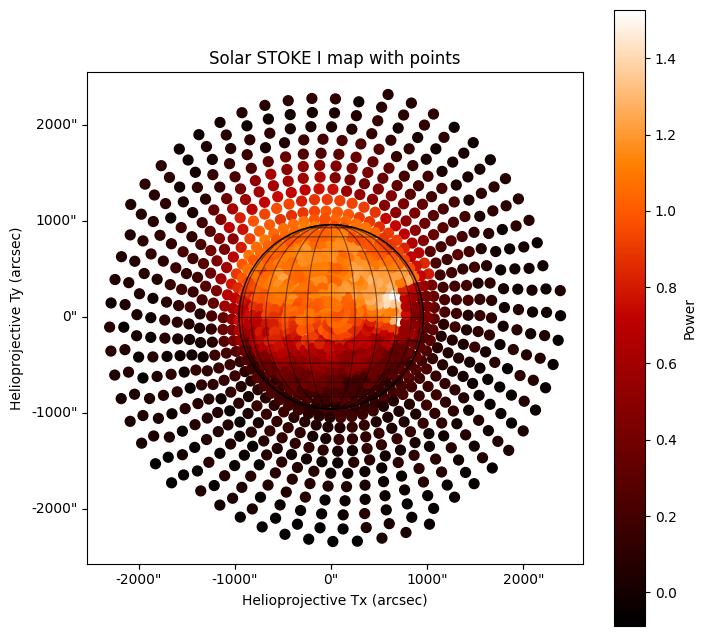

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
import sunpy.map

# Supongamos que tienes un DataFrame llamado rest_of_df y tienes dos arrays de objetos coordsXHelio y coordsYHelio
# Definir las coordenadas x e y para los puntos (SunX y SunY)
SunX = band_processed_helio_dfs["11.90GHZ"]['tx_helio_anten']
SunY = band_processed_helio_dfs["11.90GHZ"]['ty_helio_anten']
Power = processed_dfs['11.90GHZ']["STOKE_I_11.90GHZ"].values


# Definir metadatos para el mapa solar
metadata = {
    'date-obs': '2024-04-30T16:00:00',  # Ajusta esto a la fecha de observación correcta
    'crval1': 0,  
    'crval2': 0,  
    'cdelt1': 1,  
    'cdelt2': 1,  
    'cunit1': 'arcsec',  
    'cunit2': 'arcsec',  
    'ctype1': 'HPLN-TAN',  
    'ctype2': 'HPLT-TAN',  
    'crpix1': 0,  # No necesitamos esto si no estamos usando una matriz predefinida
    'crpix2': 0,  # No necesitamos esto si no estamos usando una matriz predefinida
    'waveunit': 'm',  
    'wavelnth': 0.0262897 * u.m,  
    'obsrvtry': 'Ventspils International Radio Astronomy Center',  
    'detector': 'LNSP4',  
    'dsun_obs': 1 * u.AU,  
    'hglt_obs': 0 * u.deg,  
    'hgln_obs': 0 * u.deg,  
}

# Crear un mapa solar en blanco con los metadatos
blank_map = sunpy.map.Map((np.zeros((10, 10)), metadata))

# Crear el gráfico
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection=blank_map)
blank_map.plot(axes=ax)
blank_map.draw_limb(axes=ax, color="k")
blank_map.draw_grid(axes=ax, color="k")

# Plotear los puntos en el mapa
scatter = ax.scatter(SunX, SunY, c=Power, cmap='gist_heat', s=50)

plt.colorbar(scatter,label='Power' , ax=ax) # Agregar barra de color para la intensidad
plt.title('Solar STOKE I map with points')
plt.xlabel('Helioprojective Tx (arcsec)')
plt.ylabel('Helioprojective Ty (arcsec)')
plt.grid(True)
plt.show()


In [12]:
from scipy.interpolate import Rbf

SunX = band_processed_helio_dfs["11.90GHZ"]['tx_helio_anten']
SunY = band_processed_helio_dfs["11.90GHZ"]['ty_helio_anten']
STOKE_I = processed_dfs['11.90GHZ']["STOKE_I_11.90GHZ"].values
STOKE_V = processed_dfs['11.90GHZ']["STOKE_V_11.90GHZ"].values

# Define the grid covering the helioprojective coordinate space
tx_min, tx_max = -1200, 1200
ty_min, ty_max = -1200, 1200
grid_step = 10  # Adjust as needed

# Create a grid
tx, ty = np.meshgrid(np.arange(tx_min, tx_max, grid_step),
                     np.arange(ty_min, ty_max, grid_step))

# Interpolate power values for each point on the grid using Rbf
rbf = Rbf(SunX, SunY, STOKE_I, function='linear')
interp_power_STOKE_I = rbf(tx, ty)

# Create a grid
tx, ty = np.meshgrid(np.arange(tx_min, tx_max, grid_step),
                     np.arange(ty_min, ty_max, grid_step))

# Interpolate power values for each point on the grid using Rbf
rbf = Rbf(SunX, SunY, STOKE_V, function='linear')
interp_power_STOKE_V= rbf(tx, ty)




INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


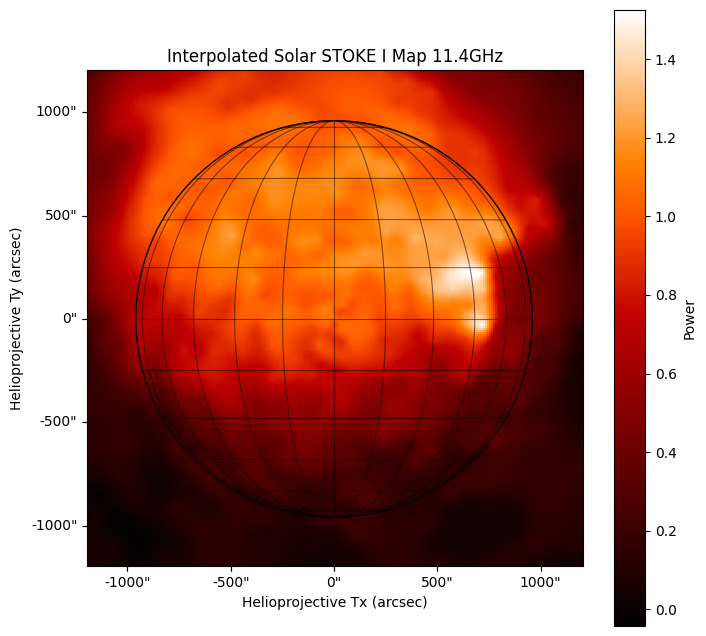

In [13]:

# Define metadata for the solar map
metadata = {
    'date-obs': '2024-04-30T16:00:00',  # Adjust this to the correct observation date
    'crval1': 0,
    'crval2': 0,
    'cdelt1': grid_step,
    'cdelt2': grid_step,
    'cunit1': 'arcsec',
    'cunit2': 'arcsec',
    'ctype1': 'HPLN-TAN',
    'ctype2': 'HPLT-TAN',
    'crpix1': (tx_max - tx_min) / (2 * grid_step),
    'crpix2': (ty_max - ty_min) / (2 * grid_step),
    'waveunit': 'm',
    'wavelnth': 0.0262897 * u.m,
    'obsrvtry': 'Ventspils International Radio Astronomy Center',
    'detector': 'LNSP4',
    'dsun_obs': 1 * u.AU,
    'hglt_obs': 0 * u.deg,
    'hgln_obs': 0 * u.deg,
}

# Create a map using the interpolated power values and metadata
interpolated_map = sunpy.map.Map((interp_power_STOKE_I, metadata))

# Plot the interpolated map using a heatmap with the 'hot' colormap
plt.figure(figsize=(8, 8))
interpolated_map.plot(cmap='gist_heat')
interpolated_map.draw_limb(color="k")
interpolated_map.draw_grid(color="k")
plt.colorbar(label='Power')
plt.title('Interpolated Solar STOKE I Map 11.4GHz')
plt.xlabel('Helioprojective Tx (arcsec)')
plt.ylabel('Helioprojective Ty (arcsec)')
plt.grid(True)
plt.show()

# Save the figure as a JPEG file
# plt.savefig('solar_map.jpeg', format='jpeg', dpi=300)

# Close the plot to free up memory
# plt.close()

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


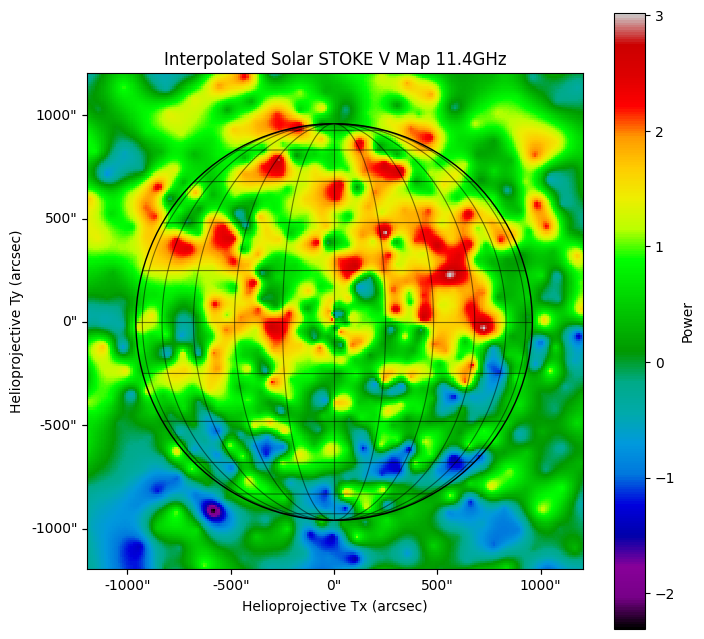

In [14]:

# Define metadata for the solar map
metadata = {
    'date-obs': '2024-04-30T16:00:00',  # Adjust this to the correct observation date
    'crval1': 0,
    'crval2': 0,
    'cdelt1': grid_step,
    'cdelt2': grid_step,
    'cunit1': 'arcsec',
    'cunit2': 'arcsec',
    'ctype1': 'HPLN-TAN',
    'ctype2': 'HPLT-TAN',
    'crpix1': (tx_max - tx_min) / (2 * grid_step),
    'crpix2': (ty_max - ty_min) / (2 * grid_step),
    'waveunit': 'm',
    'wavelnth': 0.0262897 * u.m,
    'obsrvtry': 'Ventspils International Radio Astronomy Center',
    'detector': 'LNSP4',
    'dsun_obs': 1 * u.AU,
    'hglt_obs': 0 * u.deg,
    'hgln_obs': 0 * u.deg,
}

# Create a map using the interpolated power values and metadata
interpolated_map = sunpy.map.Map((interp_power_STOKE_V, metadata))

# Plot the interpolated map using a heatmap with the 'hot' colormap
plt.figure(figsize=(8, 8))
interpolated_map.plot(cmap='nipy_spectral')
interpolated_map.draw_limb(color="k")
interpolated_map.draw_grid(color="k")
plt.colorbar(label='Power')
plt.title('Interpolated Solar STOKE V Map 11.4GHz')
plt.xlabel('Helioprojective Tx (arcsec)')
plt.ylabel('Helioprojective Ty (arcsec)')
plt.grid(True)
plt.show()
